# Import librairies

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Loading data

In [2]:
# Import train data
img_path = "../kaggle_dataset"
train_df = pd.read_csv("data/train.csv")

In [3]:
# Create the path of the image in the dataframe
train_df["path"] = train_df.apply(
    lambda x: "".join(
        [img_path, "/", str(x["patient_id"]), "_", str(x["image_id"]), ".png"]
    ),
    axis=1,
)

In [4]:
examples_list = [
    "1450_1185608765",
    "294_2044098614",
    "1461_1322198700",
    "1511_764545189",
    "1468_893864802",
    "1475_86778676",
    "1479_1933359921",
    "1493_1074894518",
    "1499_14130510",
    "1499_1988370728",
    "1511_764545189",
    "1511_1031853445",
    "1550_1451929890",
    "1653_1271242363",
    "1660_135787921",
    "1701_1613351630",
    "1719_138770970",
    "1878_1490758028",
    "1899_540562039",
    "65525_751035345",
    "393_1702011739",  # Problem ultra bright zone
    "1939_841837846",  # Whole breast super bright
    "65456_247536669",  # Some ultra bright zone
    "65271_171953953",  # Label to remove
    "38739_1189630231",
    "1511_1273092690",
    "1511_1031853445",
]

examples_list_path = [
    "".join([img_path, "/", x.split("_")[0], "_", x.split("_")[1], ".png"])
    for x in examples_list
]

# Artefact removal

Works for both annotation's labels, vertical lines if not interescts with brest

In [5]:
plt.rcParams["figure.figsize"] = (15, 15)

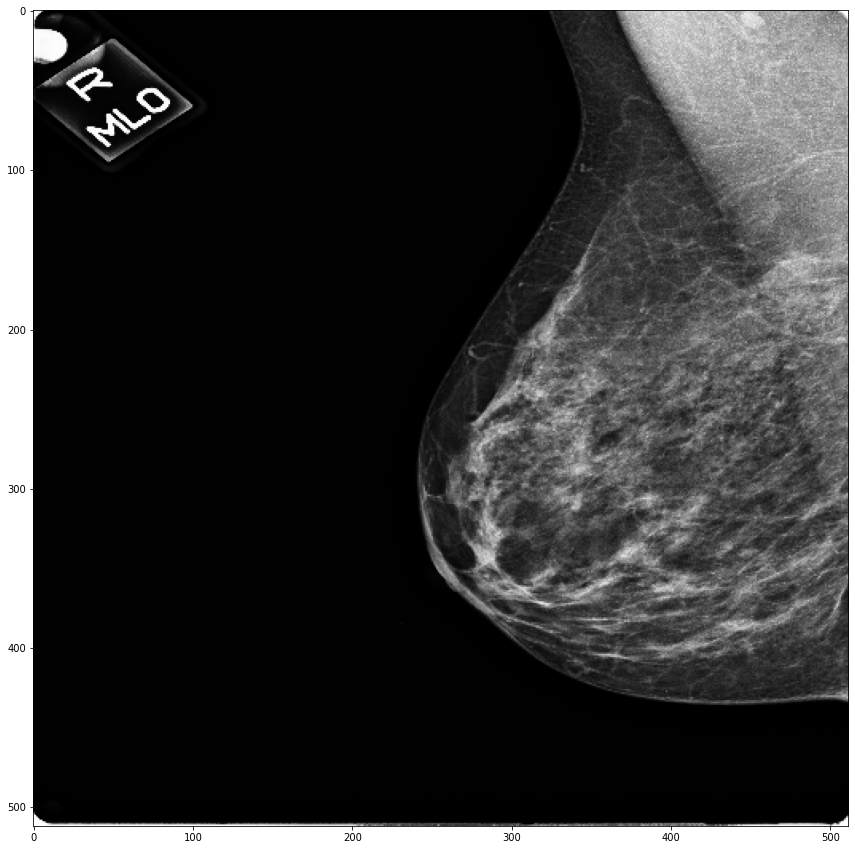

In [27]:
image = cv2.imread(examples_list_path[18])  # 10
plt.imshow(image, cmap="gray")

In [28]:
# Try to detect labels annotations (e.g, MLO) if they exist and apply a mask

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform thresholding to create a binary image
threshold, binary = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the biggest contour
biggest_contour = max(contours, key=cv2.contourArea)

# Create a mask image with the same size as the original image
mask = np.zeros_like(image)

# Draw the biggest contour on the mask image
cv2.drawContours(mask, [biggest_contour], -1, (255, 255, 255), -1)

# Create the output image by applying the mask to the original image
output = cv2.bitwise_and(image, mask)

# Create a mask image with the same size as the original image
mask_red = np.zeros_like(image)

# Draw all contours except the biggest one on the mask image
for contour in contours:
    if cv2.contourArea(contour) != cv2.contourArea(biggest_contour):
        cv2.drawContours(mask_red, [contour], -1, (255, 255, 255), -1)

# Create a copy of the original image
output_red = image.copy()

# Convert the mask image to grayscale
mask_gray = cv2.cvtColor(mask_red, cv2.COLOR_BGR2GRAY)

# Set the pixels inside the removed contours to red
output_red[mask_gray == 255] = (255, 0, 0)

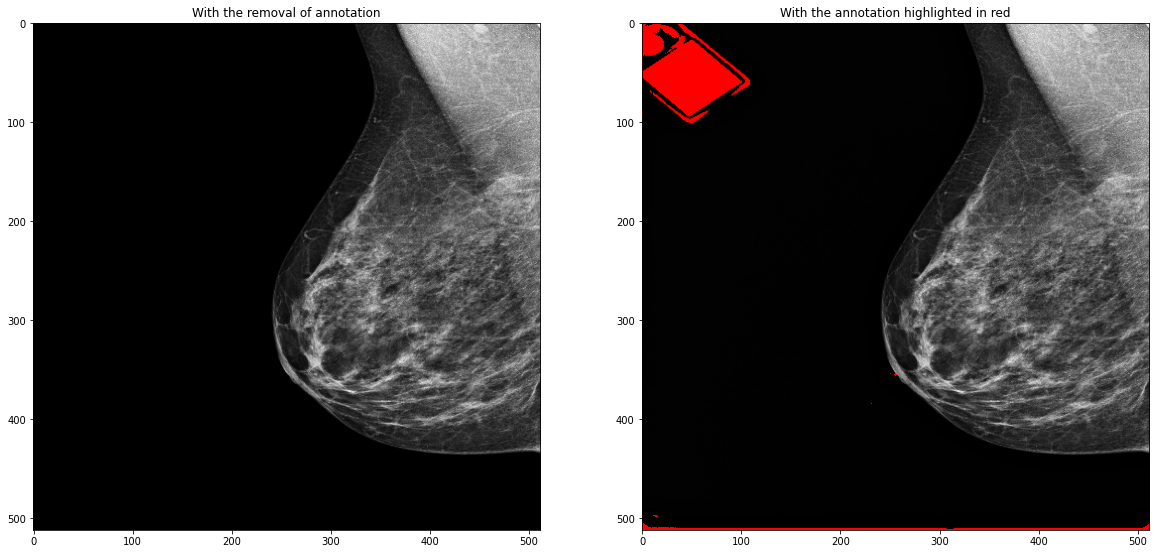

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(output)
ax1.set_title("With the removal of annotation")
ax2.imshow(output_red)
ax2.set_title("With the annotation highlighted in red")
plt.show()

# Remove horizontal or vertical white lines or black lines at top or bottom

Detection of edges

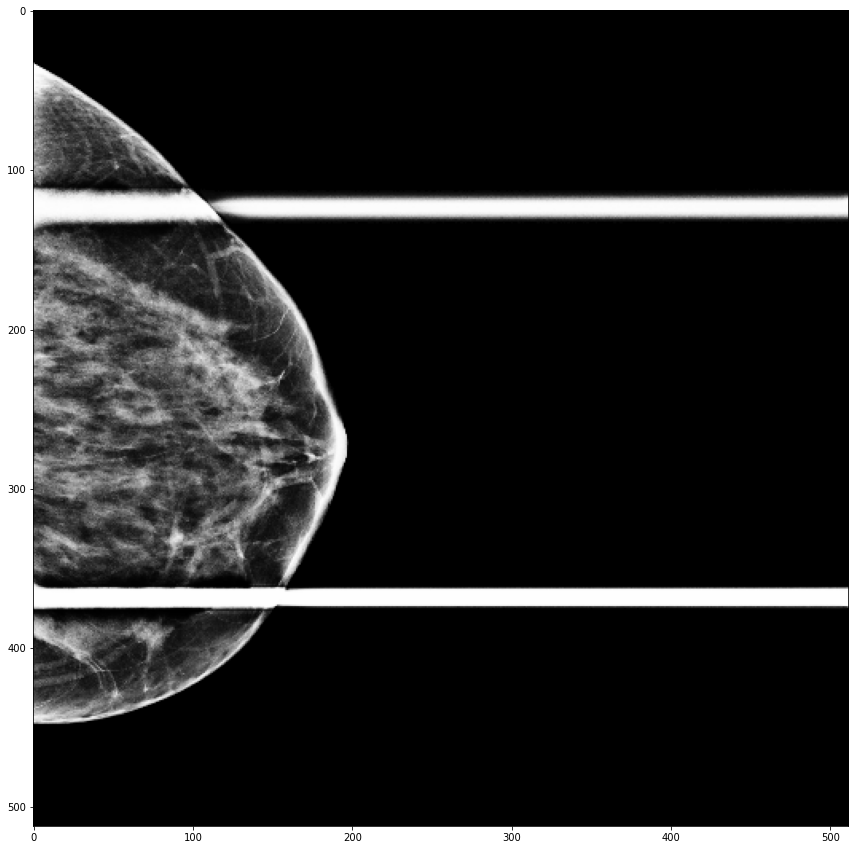

In [10]:
# image = output # To uncomment if one to see the whole pipeline
# img = cv2.imread(examples_list_path[-1])
image = cv2.imread(examples_list_path[10])
plt.imshow(image, cmap="gray")

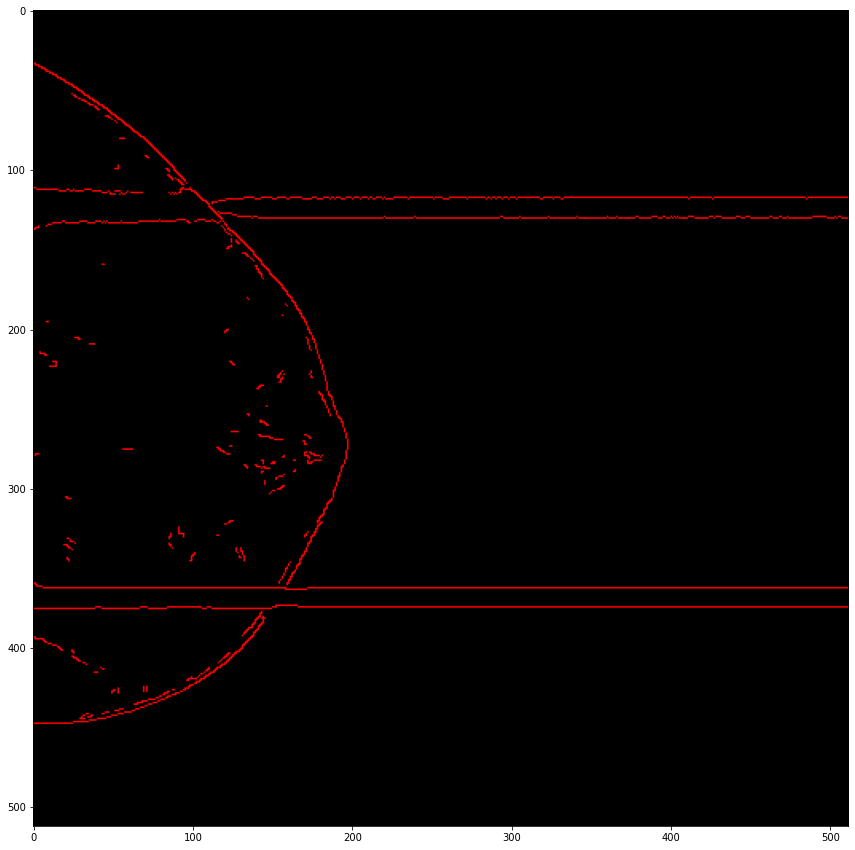

In [11]:
# Apply the Canny edge detector
edges = cv2.Canny(image, 400, 500)

# Create an empty image with the same size as the original
edges_image = np.zeros(image.shape, dtype=image.dtype)

# Set the edge pixels to white
edges_image[edges == 255] = (255, 0, 0)
plt.imshow(edges_image)

Detection of major horizontal lines (TODO do the same for vertical lines if there are) and TODO keep only 4 lines

In [12]:
# Run the probabilistic Hough line detector

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=20)
try:
    if not lines:
        lines = []
except:
    pass
filtered_lines = []
if len(lines) != 0:
    lines = sorted(
        lines,
        key=lambda x: np.sqrt((x[0][0] - x[0][2]) ** 2 + (x[0][1] - x[0][3]) ** 2),
    )
    # Keep only the longest lines
    lines = lines[-min(6, len(lines)) :]

    img_copy = image.copy()
    # Iterate over the lines and draw them on the image
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        if abs(slope) < 0.1:
            x2 = image.shape[1] - 1
            x1 = 0
            line = [[x1, y1, x2, y2]]
            filtered_lines.append(line)
            cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
    if filtered_lines:
        # Initialize the list of images
        images = []
        filtered_lines = sorted(filtered_lines, key=lambda x: x[0][1])
        # Iterate over the lines and crop the image
        y1 = 0
        for line in filtered_lines:
            y2 = line[0][1]
            images.append(image[y1:y2, :])
            y1 = y2

        # Add the final image
        images.append(image[y1:, :])

        images_shapes = [elem.shape[0] for elem in images]

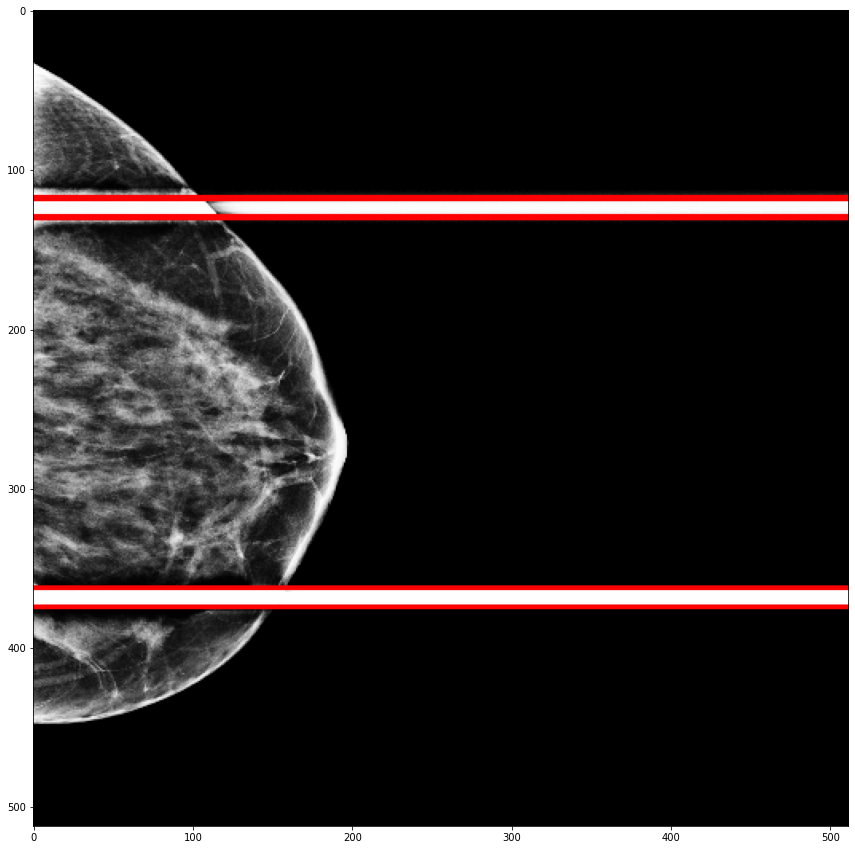

In [13]:
if filtered_lines:
    # Detect main white bands
    plt.imshow(img_copy, cmap="gray")

__Rectangles have a height of around 10 pixels__

In [14]:
inpainted_image = image.copy()
if filtered_lines and len(filtered_lines) > 1:

    thresh = 0.1
    indexes = [
        i
        for i, elem in enumerate(images)
        if elem.shape[0] > int(thresh * image.shape[0])
    ]
    zones_to_paint = [
        (filtered_lines[i - 1][0], filtered_lines[i][0])
        for i, elem in enumerate(images)
        if i not in indexes
    ]

    images = [elem[4:-4] for i, elem in enumerate(images) if i in indexes]
    images_restore = cv2.resize(np.vstack(images), image.shape[0:2])

    for zone in zones_to_paint:
        # Create a mask for the rectangle
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask[zone[0][1] - 4 : zone[1][1] + 4, 0:512] = 255
        # Inpaint the image
        inpainted_image = cv2.inpaint(inpainted_image, mask, 3, cv2.INPAINT_TELEA)

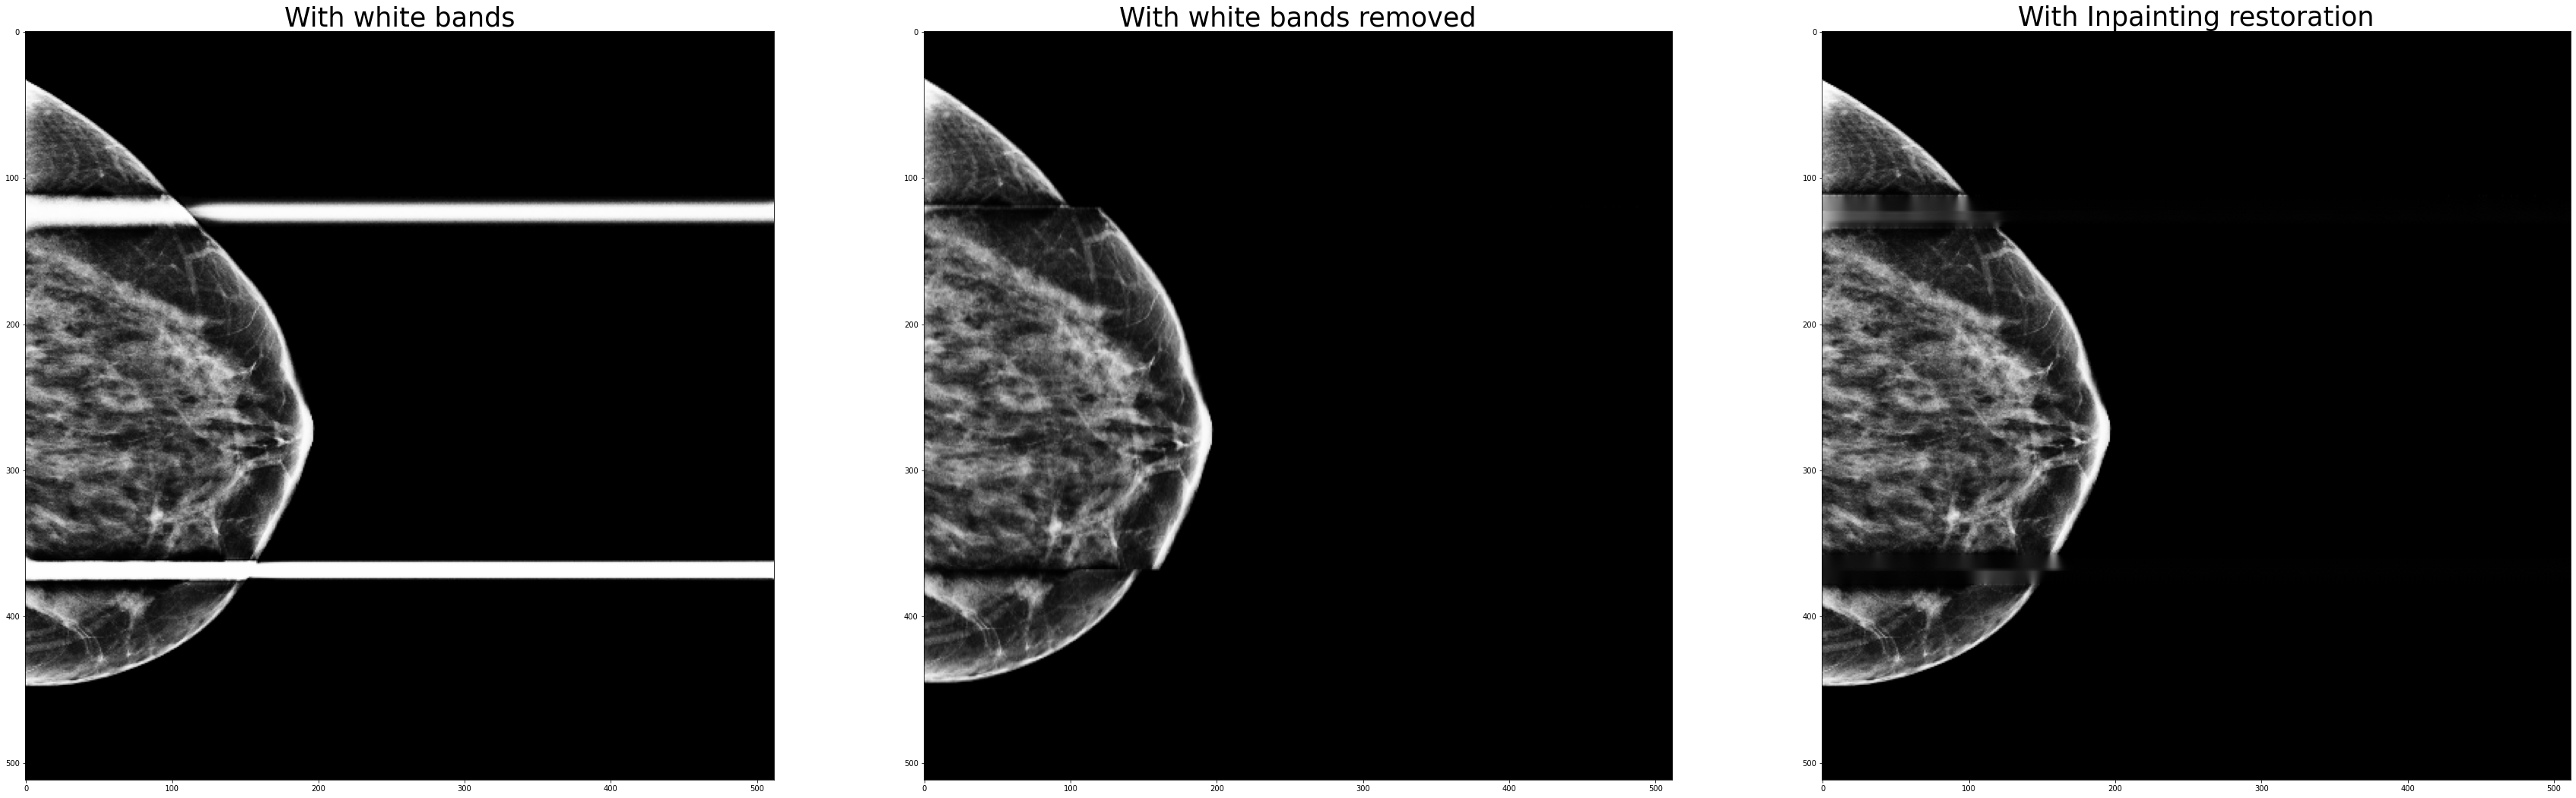

In [15]:
if filtered_lines and len(filtered_lines) > 1:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))
    ax1.imshow(image)
    ax1.set_title("With white bands", fontsize=35)
    ax2.imshow(images_restore)
    ax2.set_title("With white bands removed", fontsize=35)
    ax3.imshow(inpainted_image)
    ax3.set_title("With Inpainting restoration", fontsize=35)
    plt.show()

__TODO: Explore masked ViT to restore white bands__

# Test (for ultra bright images with too bright zones)

__Try to reconstruct with ViT if possible__

In [16]:
## Possible to ajust the threshold the threshold according to the average pixel intensity to get the too bright zone
## Ask to doctors what it could be

test = cv2.imread(examples_list_path[21])
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Perform thresholding to create a binary image
threshold, binary = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the biggest contour
biggest_contour = sorted(contours, key=cv2.contourArea)[-1]

# Create a mask image with the same size as the original image
mask = np.zeros_like(image)

# Draw the biggest contour on the mask image
cv2.drawContours(mask, [biggest_contour], -1, (255, 255, 255), -1)

# Create the output image by applying the mask to the original image
output = cv2.bitwise_and(test, mask)

# Create a mask image with the same size as the original image
mask_red = np.zeros_like(test)

# Draw all contours except the biggest one on the mask image

cv2.drawContours(mask_red, [biggest_contour], -1, (255, 255, 255), -1)

# Create a copy of the original image
output_red = test.copy()


# Convert the mask image to grayscale
mask_gray = cv2.cvtColor(mask_red, cv2.COLOR_BGR2GRAY)

# Set the pixels inside the removed contours to red
output_red[mask_gray == 255] = (255, 0, 0)

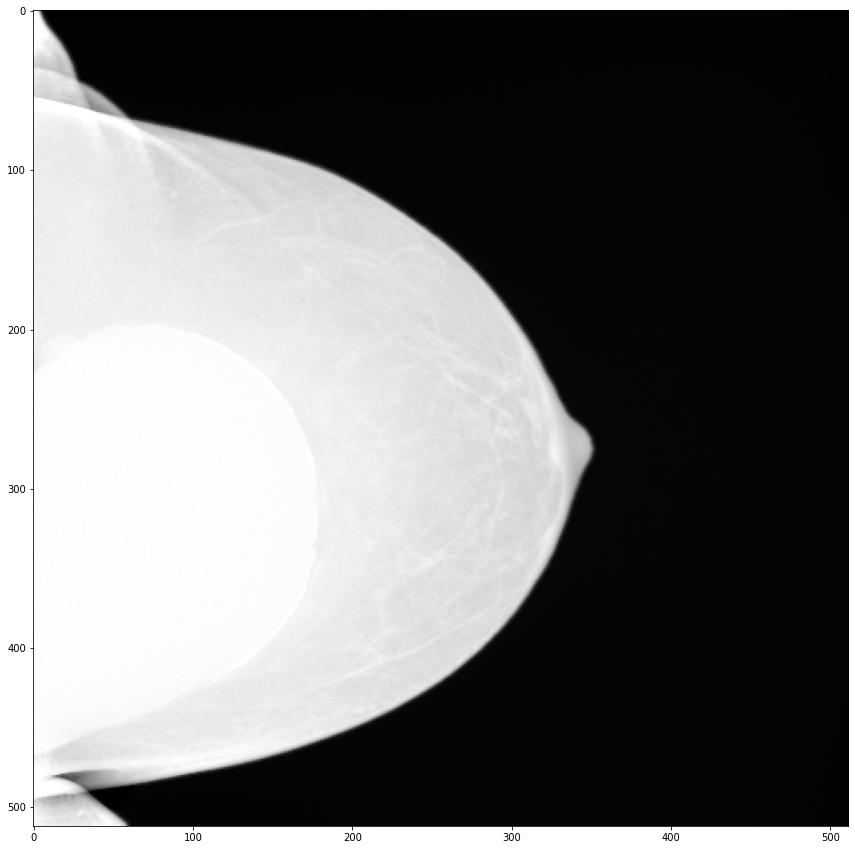

In [17]:
plt.imshow(test, cmap="gray")

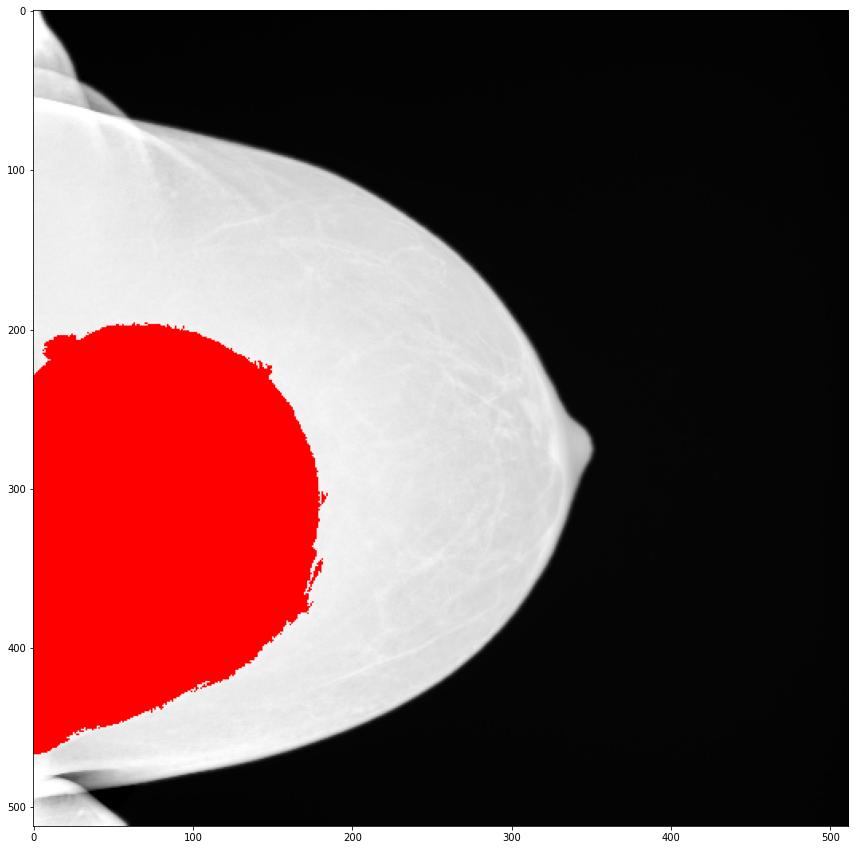

In [18]:
plt.imshow(output_red)

In [19]:
## Possible to ajust the threshold the threshold according to the average pixel intensity to get the too bright zone
## Ask to doctors what it could be

test = cv2.imread(examples_list_path[14])
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Perform thresholding to create a binary image
threshold, binary = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the biggest contour
biggest_contour = sorted(contours, key=cv2.contourArea)[-1]

# Create a mask image with the same size as the original image
mask = np.zeros_like(image)

# Draw the biggest contour on the mask image
cv2.drawContours(mask, [biggest_contour], -1, (255, 255, 255), -1)

# Create the output image by applying the mask to the original image
output = cv2.bitwise_and(test, mask)

# Create a mask image with the same size as the original image
mask_red = np.zeros_like(test)

# Draw all contours except the biggest one on the mask image

cv2.drawContours(mask_red, [biggest_contour], -1, (255, 255, 255), -1)

# Create a copy of the original image
output_red = test.copy()


# Convert the mask image to grayscale
mask_gray = cv2.cvtColor(mask_red, cv2.COLOR_BGR2GRAY)

# Set the pixels inside the removed contours to red
output_red[mask_gray == 255] = (255, 0, 0)

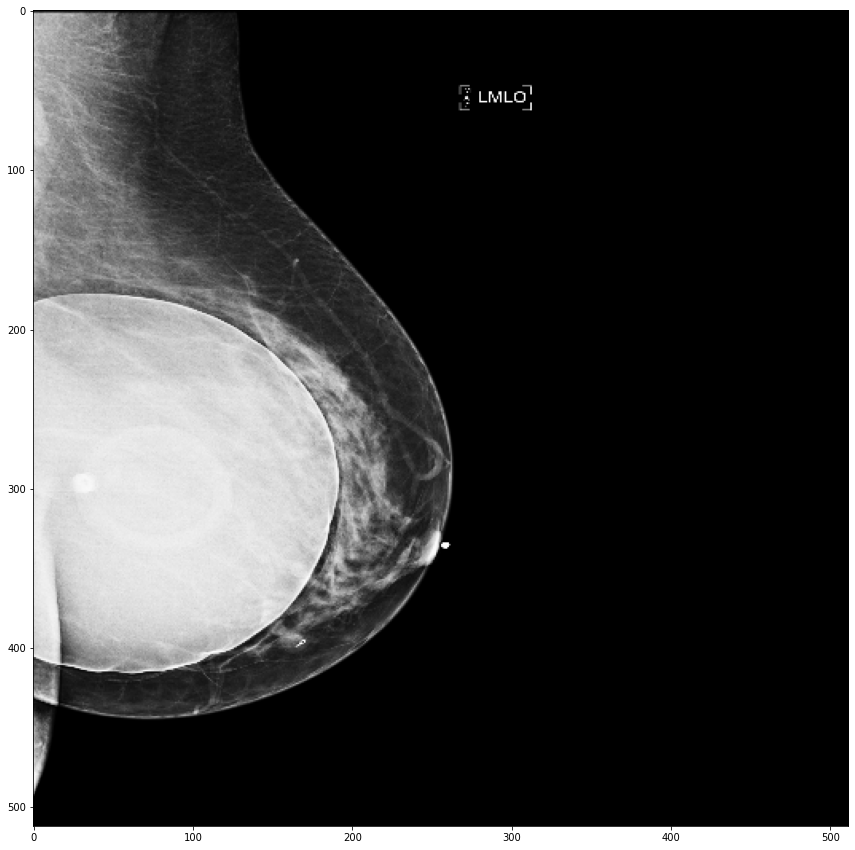

In [20]:
plt.imshow(test, cmap="gray")

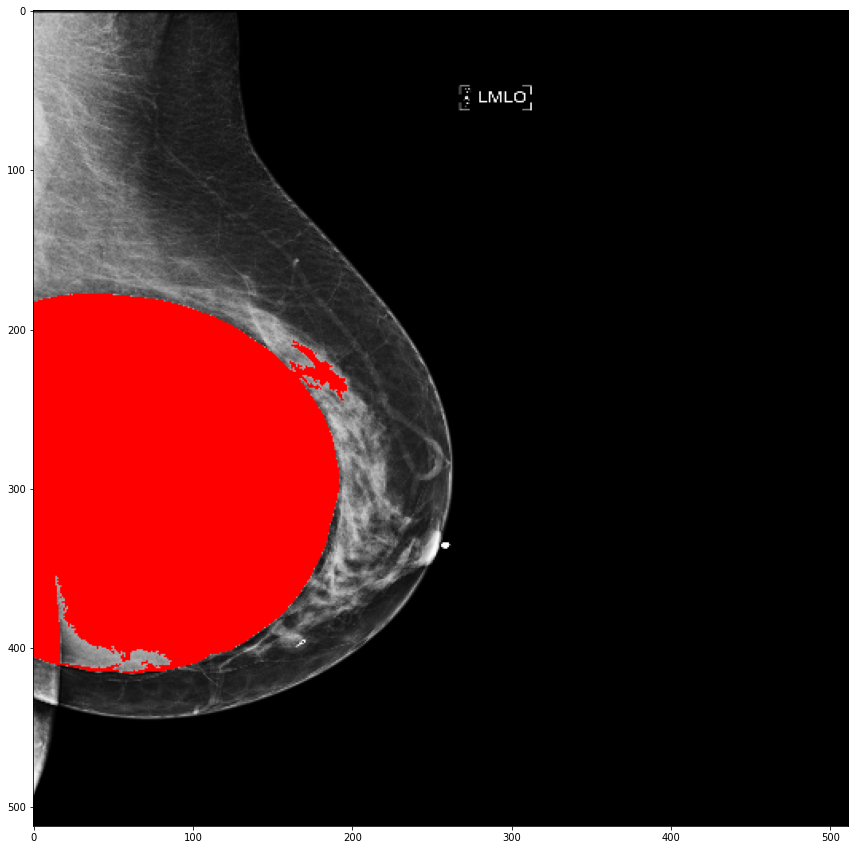

In [21]:
plt.imshow(output_red, cmap="gray")

# Image normalization and enhancement

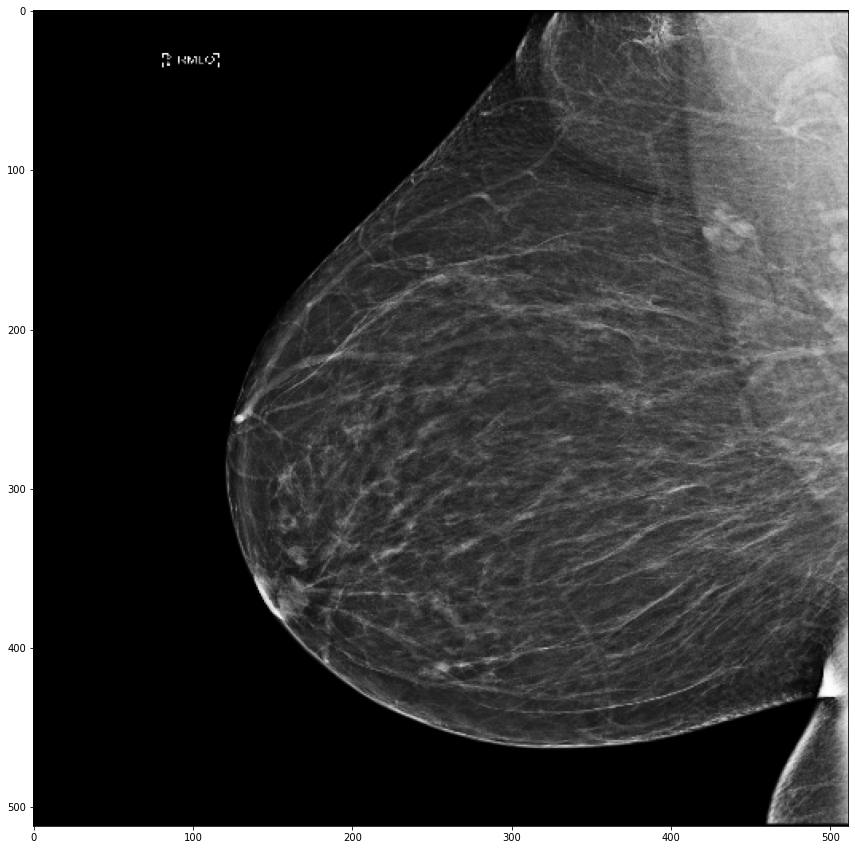

In [34]:
image = cv2.imread(examples_list_path[6])  # 18
plt.imshow(image, cmap="gray")

In [37]:
# Classical normalization with Open CV
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
out = cv2.equalizeHist(gray)

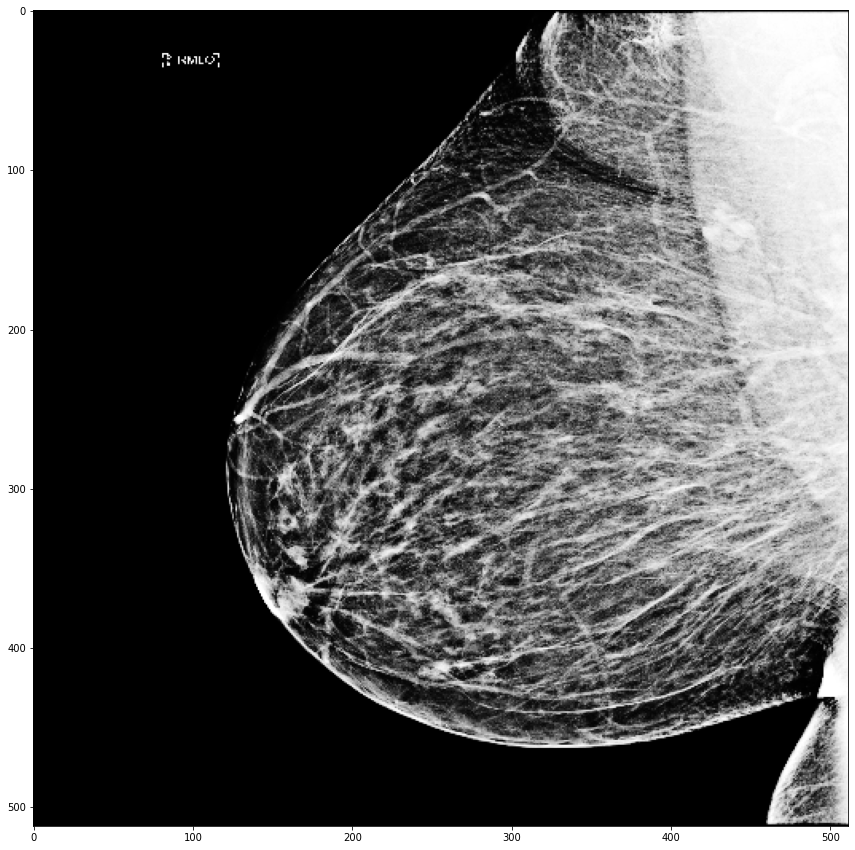

In [40]:
plt.imshow(out, cmap="gray")

__Might to be too harsh to apply a global histogram enhancement__

__With CLAE (cf. https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)__

__TODO: Apply a mask on the contour for equalization__

In [50]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl1 = clahe.apply(gray)

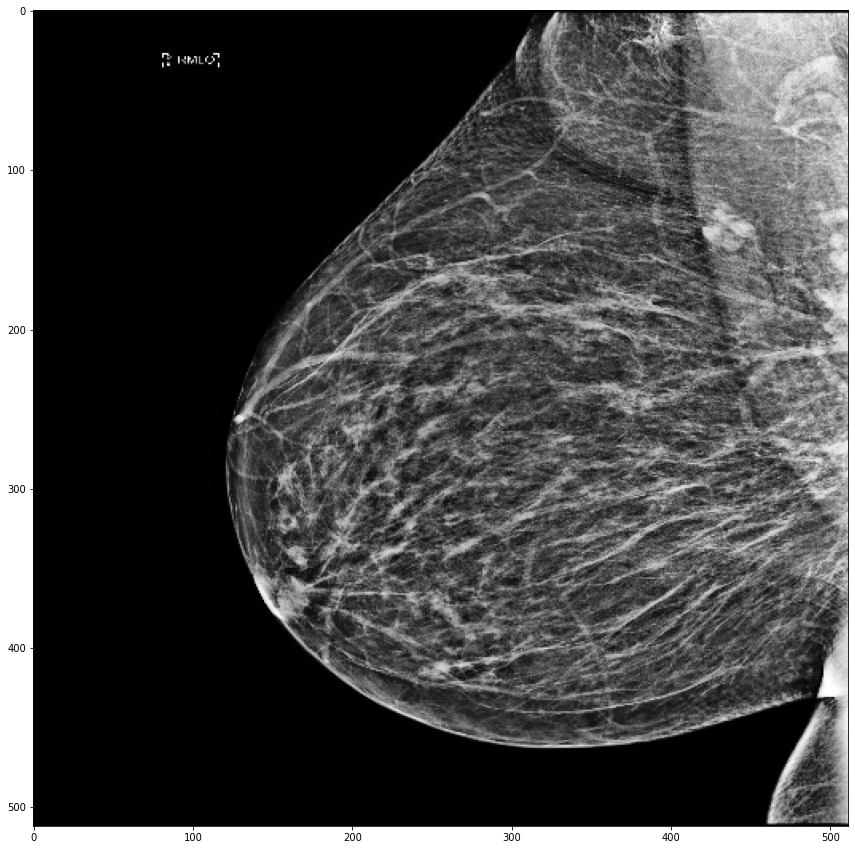

In [51]:
plt.imshow(cl1, cmap="gray")

# Image denoising?

# Image sharpening?

# Image normalization?